In [1]:
!pip install -q langchain google-generativeai huggingface_hub transformers spacy torch langchain_community langchain-google-genai
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
import spacy
import torch
from transformers import pipeline
from huggingface_hub import InferenceClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from IPython.display import Image as IPyImage, display
import os

# HuggingFace Login

In [8]:
from google.colab import userdata

from huggingface_hub import login
login(token=userdata.get("HUGGINGFACE_TOKEN"))


# Load spaCy and sentiment models

In [2]:
nlp = spacy.load("en_core_web_sm")
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


# Load Google Gemini And Stable Diffusion

In [4]:
import os
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY_1')

In [14]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.3
)


image_client = InferenceClient(model="stabilityai/stable-diffusion-3.5-large")

# Function Definitions

In [23]:
from PIL import Image
import io

def analyze_sentiment(prompt):
    result = sentiment_analyzer(prompt)[0]
    return result['label']

def extract_named_entities(prompt):
    doc = nlp(prompt)
    return [ent.text for ent in doc.ents]

def classify_request_type(prompt):
    classification_prompt = f"""Classify this prompt into one of the categories:
    - text
    - image
    - translation

    Prompt: "{prompt}"
    Only return one word: text, image, or translation."""

    response = llm([HumanMessage(content=classification_prompt)])
    return response.content.strip().lower()

def handle_text_request(prompt):
    response = llm([HumanMessage(content=prompt)])
    return response.content.strip()


def generate_image_and_captions(prompt):

    pil_image = image_client.text_to_image(prompt, guidance_scale=7.5)

    img_path = "generated_image.png"
    pil_image.save(img_path)

    caption_prompt = f"Generate 3 creative captions for an image based on: {prompt}"
    captions = llm([HumanMessage(content=caption_prompt)]).content.strip().split('\n')
    captions = [cap.strip("-• ") for cap in captions if cap.strip()]

    return img_path, captions


def translate_prompt(prompt, target_lang="fr"):
    translate_prompt = f"Translate the text :\n\n{prompt}"
    return llm([HumanMessage(content=translate_prompt)]).content.strip()


# Chatbot

Welcome to SmartBot in Colab! Type 'exit' to quit.

You: Tell me interesting facts about monarch butterflies.

[Sentiment]: POSITIVE
[Named Entities]: []
[Request Type]: text
[Response]: Okay, here are some interesting facts about Monarch butterflies, covering their migration, life cycle, and more:

**Migration & Navigation:**

*   **Epic Migration:** Monarch butterflies undertake one of the most spectacular migrations on Earth. Eastern North American Monarchs travel thousands of miles from breeding grounds in Canada and the US to overwintering sites in the oyamel fir forests of central Mexico. Western Monarchs migrate to overwintering sites along the California coast.
*   **Multi-Generational Journey:** The butterflies that complete the migration to Mexico or California are actually the *great-great-grandchildren* of the butterflies that left those overwintering sites in the spring. It takes 4-5 generations to complete the full cycle.
*   **Solar Compass:** Monarchs use a combination 

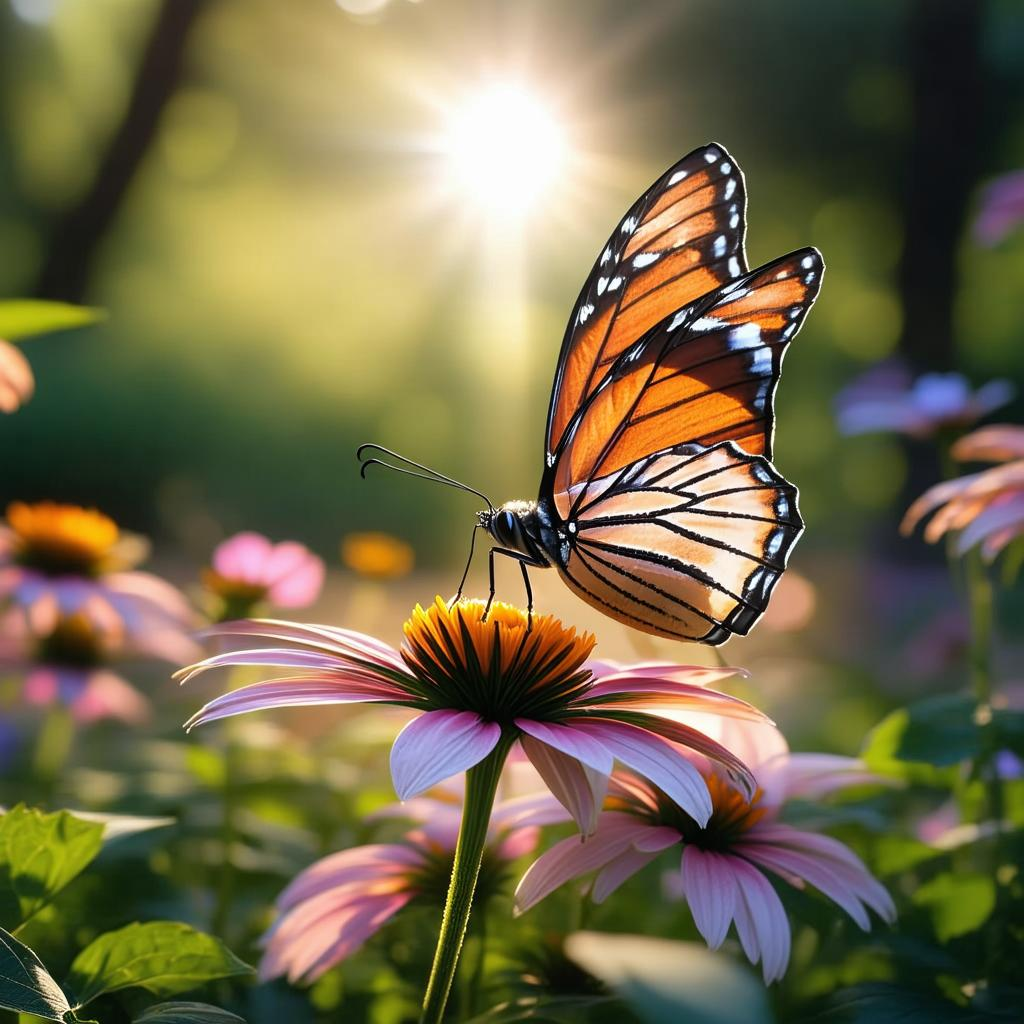

In [ ]:
print("Welcome to SmartBot in Colab! Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")

    if user_input.lower() == "exit":
        print("Goodbye!")
        break

    sentiment = analyze_sentiment(user_input)
    entities = extract_named_entities(user_input)
    task_type = classify_request_type(user_input)

    print(f"\n[Sentiment]: {sentiment}")
    print(f"[Named Entities]: {entities}")
    print(f"[Request Type]: {task_type}")

    if task_type == "text":
        response = handle_text_request(user_input)
        print(f"[Response]: {response}\n")

    elif task_type == "image":
        img_path, captions = generate_image_and_captions(user_input)
        print("[Captions]:")
        for i, cap in enumerate(captions, 1):
            print(f"  {i}. {cap}")
        display(IPyImage(filename=img_path))

    elif task_type == "translation":
        translation = translate_prompt(user_input)
        print(f"[Translated]: {translation}\n")

    else:
        print("[Error]: Unrecognized request type.\n")
